<a href="https://colab.research.google.com/github/gpapadok/gan-pytorch-mnist/blob/master/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
# PARAMETERS
LR = .0002
BETA1 = .5
BETA2 = .999
BATCH_SIZE = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5,), (.5,))
     ])

try:
  trainset = torchvision.datasets.MNIST('./data', transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
except RuntimeError:
  trainset = torchvision.datasets.MNIST('./data', download=True, transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# print(trainset)
# print(testset)

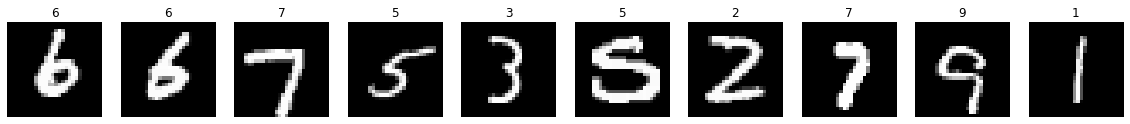

In [ ]:
def plot_digits(dataset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.ConvTranspose2d(100, 512, 5)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.ConvTranspose2d(512, 128, 4)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.ConvTranspose2d(64, 32, 5, 2)
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.ConvTranspose2d(32, 1, 4)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input):
    x = input.view(-1, 100, 1, 1)
    x = self.bn1(self.conv1(x))
    x = self.leaky_relu(x)
    x = self.bn2(self.conv2(x))
    x = self.leaky_relu(x)
    x = self.bn3(self.conv3(x))
    x = self.leaky_relu(x)
    x = self.bn4(self.conv4(x))
    x = self.leaky_relu(x)
    x = self.conv5(x)

    return torch.tanh(x)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 4)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 4)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 5, 2)
    self.bn4 = nn.BatchNorm2d(256)
    self.fc = nn.Linear(256 * 7 * 7, 1)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input):
    x = self.bn1(self.conv1(input))
    x = self.leaky_relu(x)
    x = self.bn2(self.conv2(x))
    x = self.leaky_relu(x)
    x = self.bn3(self.conv3(x))
    x = self.leaky_relu(x)
    x = self.bn4(self.conv4(x))
    x = self.leaky_relu(x)
    x = self.fc(x.view(-1, 256 * 7 * 7))
    return torch.sigmoid(x)

In [ ]:
class GAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch):
    return self.generator(batch)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    fake = self.generate_fake(noise).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs=EPOCHS, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_history = []
    try:
      for epoch in range(epochs):
        if epoch % 5 == 0:
          self.plot_ten_samples()
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          for _ in range(1):
            self.optimD.zero_grad()

            # Train with real
            real = data[0].to(device)
            batch_size = real.size()[0]
            real_labels = torch.ones(batch_size, 1, device=device) * .9
            out = self.discriminator(real)
            errD_real = self.loss(out, real_labels)
            errD_real.backward()

            # Train with fake
            noise = torch.randn(batch_size, 100, device=device)
            fake = self.generate_fake(noise)
            fake_labels = torch.ones(batch_size, 1, device=device) * .1
            out = self.discriminator(fake)
            errD_fake = self.loss(out, fake_labels)
            errD_fake.backward()

            self.optimD.step()

          errD_history += [errD_real+errD_fake]

          # TRAIN GENERATOR
          self.optimG.zero_grad()

          noise = torch.randn(batch_size, 100, device=device)
          fake = self.generate_fake(noise)
          fake_labels = torch.ones(batch_size, 1, device=device)
          out = self.discriminator(fake)
          errG = self.loss(out, fake_labels)
          errG.backward()

          self.optimG.step()

          errG_history += [errG]

        print(f'EPOCH {epoch+1:2}: Dloss {errD_history[-1]:.4f} Gloss {errG_history[-1]:.4f}')
    except KeyboardInterrupt:
      return errG_history, errD_history


          
    return errG_history, errD_history

In [ ]:
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [ ]:
loss = nn.BCELoss()
optimizerD = optim.Adam(dnet.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizerG = optim.Adam(gnet.parameters(), lr=LR, betas=(BETA1, BETA2))

gan = GAN(gnet, dnet, loss, optimizerG, optimizerD)

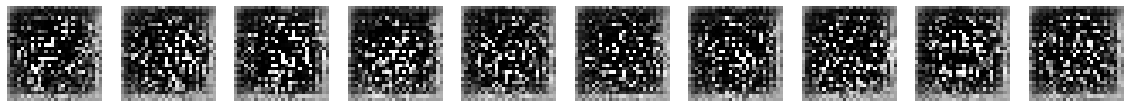

EPOCH  1: Dloss 0.9552 Gloss 2.9309
EPOCH  2: Dloss 0.7825 Gloss 1.6147
EPOCH  3: Dloss 0.7156 Gloss 2.0874
EPOCH  4: Dloss 0.9284 Gloss 2.6099
EPOCH  5: Dloss 0.9289 Gloss 1.1651


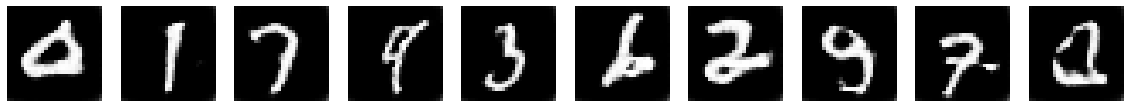

EPOCH  6: Dloss 0.7697 Gloss 1.9561
EPOCH  7: Dloss 0.7563 Gloss 1.8586
EPOCH  8: Dloss 0.7992 Gloss 2.1826
EPOCH  9: Dloss 0.8791 Gloss 1.8564
EPOCH 10: Dloss 1.0275 Gloss 2.5816


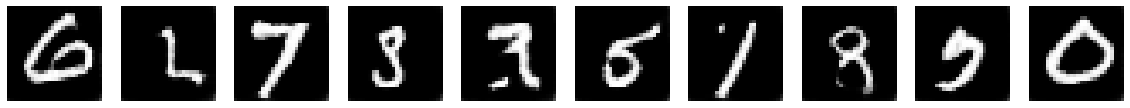

EPOCH 11: Dloss 0.7730 Gloss 2.7946
EPOCH 12: Dloss 0.8286 Gloss 2.2121
EPOCH 13: Dloss 0.8280 Gloss 2.2744
EPOCH 14: Dloss 0.7610 Gloss 1.8999
EPOCH 15: Dloss 0.8297 Gloss 1.1359


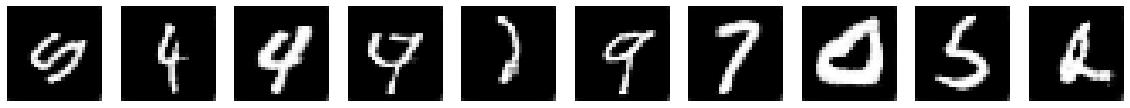

EPOCH 16: Dloss 0.7528 Gloss 2.5024
EPOCH 17: Dloss 0.7195 Gloss 1.8114
EPOCH 18: Dloss 0.9616 Gloss 2.2725
EPOCH 19: Dloss 0.8808 Gloss 3.9252
EPOCH 20: Dloss 0.7313 Gloss 1.6752


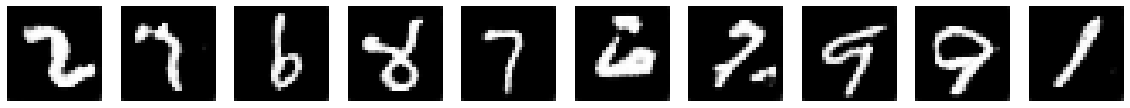

EPOCH 21: Dloss 0.8113 Gloss 1.4791
EPOCH 22: Dloss 0.7967 Gloss 1.2261
EPOCH 23: Dloss 0.7469 Gloss 1.7576
EPOCH 24: Dloss 0.7884 Gloss 1.5764
EPOCH 25: Dloss 0.7793 Gloss 1.9972


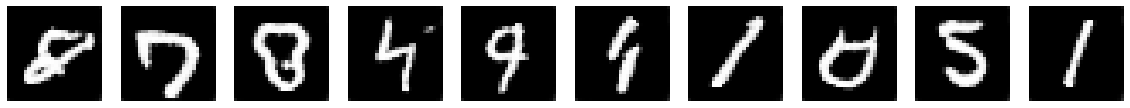

EPOCH 26: Dloss 0.7606 Gloss 2.5541
EPOCH 27: Dloss 0.8700 Gloss 2.4426
EPOCH 28: Dloss 0.8494 Gloss 1.6489
EPOCH 29: Dloss 0.8429 Gloss 2.2085
EPOCH 30: Dloss 0.7901 Gloss 2.3283


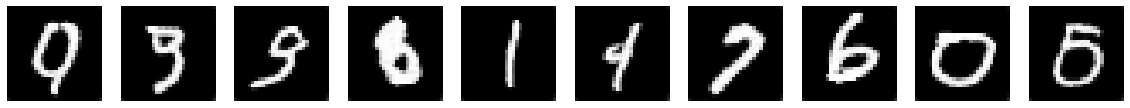

EPOCH 31: Dloss 0.7941 Gloss 2.3092
EPOCH 32: Dloss 0.8012 Gloss 1.6307
EPOCH 33: Dloss 0.7597 Gloss 2.5377
EPOCH 34: Dloss 0.9599 Gloss 3.2296
EPOCH 35: Dloss 0.7407 Gloss 3.2888


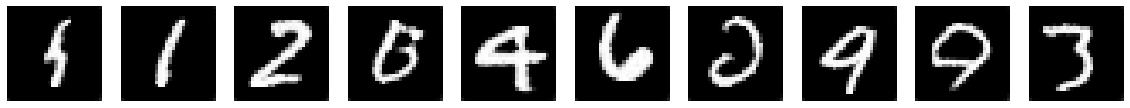

EPOCH 36: Dloss 0.8094 Gloss 1.7465
EPOCH 37: Dloss 0.6934 Gloss 2.4778
EPOCH 38: Dloss 0.7687 Gloss 2.2355
EPOCH 39: Dloss 0.7770 Gloss 2.0357
EPOCH 40: Dloss 0.8127 Gloss 1.1891


In [ ]:
errorG_history, errorD_history = gan.train(trainset, epochs=40)

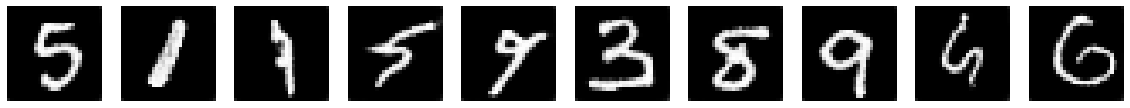

In [ ]:
gan.plot_ten_samples()

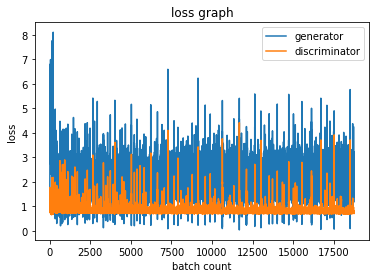

In [ ]:
plt.plot(errorG_history)
plt.plot(errorD_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['generator','discriminator'])